Import stuff and initialize global parameters.

In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.layers import Conv2D, Flatten, Dense, LSTM, \
    MaxPooling2D
from keras.models import Sequential
from common import extract_training_data, generate_multifile

IMAGE_SIZE = (64, 64, 3)

Using TensorFlow backend.


# LSTM network
Reading data and creating initial model.

In [3]:
video_names = ["20171211-182708258.h264",
             "20171211-183607508.h264",
             "20171211-184640781.h264",
             "20171211-185037299.h264",
             "20171211-191157767.h264"
              ]

csv_names = ["20171211-182708258.csv",
             "20171211-183607508.csv",
             "20171211-184640781.csv",
             "20171211-185037299.csv",
             "20171211-191157767.csv"
            ]

data_gen = generate_multifile(video_names, csv_names)

asd = next(data_gen)
print(asd[1])

for i in range(1200):
    next(data_gen)

dsa = next(data_gen)
print(dsa[1])


[[  1.52590219e-05   5.00000000e-01   5.00000000e-01]]
[[ 0.86911768  0.          0.82533336]]


In [3]:
from keras.layers import Permute, Reshape

def create_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), kernel_initializer="he_normal", activation='relu', input_shape=IMAGE_SIZE))
    model.add(MaxPooling2D((2, 2)))
    model.add(Permute((3, 2, 1)))
    model.add(Reshape((4, 7688)))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dense(3, activation='linear'))

    model.compile(loss="mse", optimizer="adam")
    
    return model

model = create_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
permute_1 (Permute)          (None, 32, 31, 31)        0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 7688)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                1984768   
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 195       
Total params: 1,985,859
Trainable params: 1,985,859
Non-trainable params: 0
_________________________________________________________________


### LSTM network results

In [4]:
history = model.fit_generator(data_gen, steps_per_epoch=3000, epochs=10)

Epoch 1/10
3000/3000 [==============================] - 39s - loss: 0.0265    
Epoch 2/10
3000/3000 [==============================] - 36s - loss: 0.0595    
Epoch 3/10
3000/3000 [==============================] - 36s - loss: 0.1016    
Epoch 4/10
3000/3000 [==============================] - 37s - loss: 0.1135    
Epoch 5/10
3000/3000 [==============================] - 36s - loss: 0.0753    
Epoch 6/10
3000/3000 [==============================] - 36s - loss: 0.1145    
Epoch 7/10
3000/3000 [==============================] - 36s - loss: 0.0994    
Epoch 8/10
3000/3000 [==============================] - 37s - loss: 0.1370    
Epoch 9/10
3000/3000 [==============================] - 37s - loss: 0.1577    
Epoch 10/10
3000/3000 [==============================] - 37s - loss: 0.0914    


In [5]:
test_images, test_labels = extract_training_data("Data/20171029-201949.h264.avi", 
                                                            "Data/20171029-201949.h264.csv", 
                                                            IMAGE_SIZE)

prediction = model.predict(test_images)

In [6]:
prediction

array([[  1.77859008e-01,  -3.18855047e-04,   5.82868516e-01],
       [  1.77859008e-01,  -3.18855047e-04,   5.82868516e-01],
       [  1.77859008e-01,  -3.18855047e-04,   5.82868516e-01],
       ..., 
       [  1.77859008e-01,  -3.18855047e-04,   5.82868516e-01],
       [  1.77859008e-01,  -3.18855047e-04,   5.82868516e-01],
       [  1.77859008e-01,  -3.18855047e-04,   5.82868516e-01]], dtype=float32)

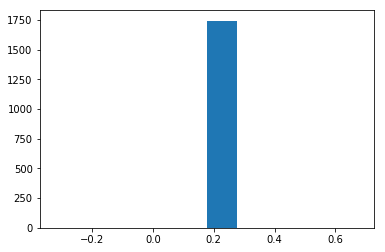

In [7]:
plt.hist(prediction[:, 0])
plt.show()

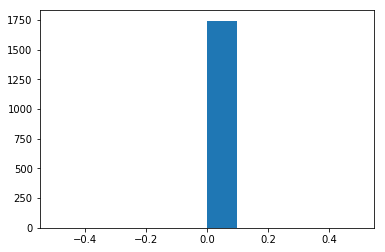

In [8]:
plt.hist(prediction[:, 1])
plt.show()

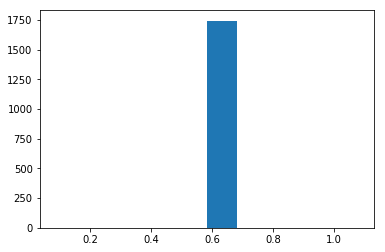

In [9]:
plt.hist(prediction[:, 2])
plt.show()

In [10]:
validation_labels = test_labels.as_matrix(columns=test_labels.columns[1: -1])
clipped_prediction = np.zeros_like(prediction)

clipped_prediction[:, 0] = np.clip(prediction[:, 0], -1, 1)
clipped_prediction[:, 1] = np.clip(prediction[:, 1], 0, 1)
clipped_prediction[:, 2] = np.clip(prediction[:, 2], 0, 1)

print(validation_labels.shape)
print(clipped_prediction.shape)

(1744, 3)
(1744, 3)


In [11]:
from sklearn.metrics import explained_variance_score
explained_variance_score(validation_labels, prediction)

-1.0362081563168128e-15

## K fold cross validation

Currently the model is just a copy of what is above, defined as a function for the KerasRegressor wrapper

In [28]:
from common import run_kfold_cross_val

# Concatenate both videos
total_images = np.concatenate((images, test_images), axis=0)
total_labels = np.concatenate((labels, test_labels), axis=0)

total_y_train = total_labels[:, 1:-1]

results = run_kfold_cross_val(create_model, total_images, total_y_train)
print(results)
print(results.mean())
print(np.median(results))

(7855,)
(873,)


AssertionError: 